G[4] = {('circular', '?', '?', '?', 'thin'), ('oval', '?', 'light', 'smooth', '?'), ('?', 'small', '?', '?', 'thin'), ('?', 'small', 'dark', '?', '?'), ('?', '?', 'light', '?', 'thin'), ('oval', 'small', '?', '?', '?'), ('?', '?', 'dark', 'irregular', '?'), ('circular', '?', 'dark', '?', '?'), ('?', '?', 'dark', '?', 'thick'), ('oval', '?', '?', 'smooth', 'thick'), ('?', 'small', '?', 'irregular', '?'), ('?', '?', '?', 'irregular', 'thin')}
S[4] = {('0', '0', '0', '0', '0')}
Populating the interactive namespace from numpy and matplotlib



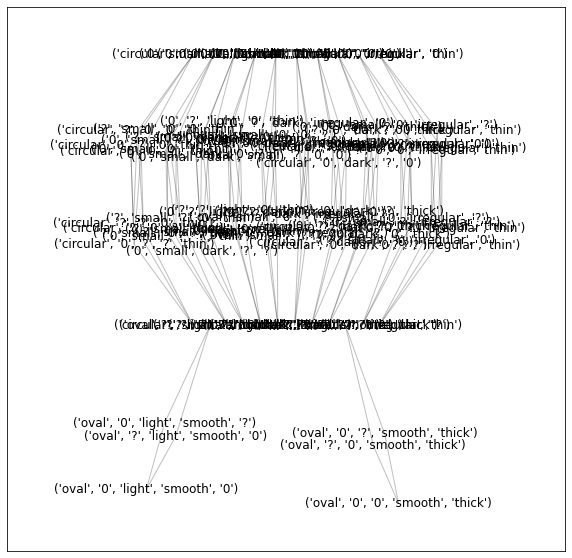

In [4]:
import random
import csv
import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Rectangle
from IPython.html.widgets import interact, IntSlider

def g_0(n):
    return ("?",)*n

def s_0(n):
    return ('0',)*n


def more_general(h1, h2):
    more_general_parts = []
    for x, y in zip(h1, h2):
        mg = x == "?" or (x != "0" and (x == y or y == "0"))
        more_general_parts.append(mg)
    return all(more_general_parts)

l1 = [1, 2, 3]
l2 = [3, 4, 5]

list(zip(l1, l2))

def fulfills(example, hypothesis):
    ### the implementation is the same as for hypotheses:
    return more_general(hypothesis, example)

def min_generalizations(h, x):
    h_new = list(h)
    for i in range(len(h)):
        if not fulfills(x[i:i+1], h[i:i+1]):
            h_new[i] = '?' if h[i] != '0' else x[i]
    return [tuple(h_new)]


min_generalizations(h=('0', '0'  , 'sunny'), 
                    x=('rainy', 'windy', 'cloudy'))

[('rainy', 'windy', '?')]
def min_specializations(h, domains, x):
    results = []
    for i in range(len(h)):
        if h[i] == "?":
            for val in domains[i]:
                if x[i] != val:
                    h_new = h[:i] + (val,) + h[i+1:]
                    results.append(h_new)
        elif h[i] != "0":
            h_new = h[:i] + ('0',) + h[i+1:]
            results.append(h_new)
    return results

min_specializations(h=('?', 'x',), 
                    domains=[['a', 'b', 'c'], ['x', 'y']], 
                    x=('b', 'x'))

with open('c3.csv')  as csvFile:
        examples = [tuple(line) for line in csv.reader(csvFile)]

def get_domains(examples):
    d = [set() for i in examples[0]]
    for x in examples:
        for i, xi in enumerate(x):
            d[i].add(xi)
    return [list(sorted(x)) for x in d]

get_domains(examples)

def candidate_elimination(examples):
    domains = get_domains(examples)[:-1]
    
    G = set([g_0(len(domains))])
    S = set([s_0(len(domains))])
    i=0
    #print("\n G[{0}]:".format(i),G)
    #print("\n S[{0}]:".format(i),S)
    for xcx in examples:
        i=i+1
        x, cx = xcx[:-1], xcx[-1]  # Splitting data into attributes and decisions
        if cx=='Y': # x is positive example
            G = {g for g in G if fulfills(x, g)}
            S = generalize_S(x, G, S)
        else: # x is negative example
            S = {s for s in S if not fulfills(x, s)}
            G = specialize_G(x, domains, G, S)
        #print("\n G[{0}]:".format(i),G)
        #print("\n S[{0}]:".format(i),S)
    return G,S

def generalize_S(x, G, S):
    S_prev = list(S)
    for s in S_prev:
        if s not in S:
            continue
        if not fulfills(x, s):
            S.remove(s)
            Splus = min_generalizations(s, x)
            ## keep only generalizations that have a counterpart in G
            S.update([h for h in Splus if any([more_general(g,h) 
                                               for g in G])])
            ## remove hypotheses less specific than any other in S
            S.difference_update([h for h in S if 
                                 any([more_general(h, h1) 
                                      for h1 in S if h != h1])])
    return S


def specialize_G(x, domains, G, S):
    G_prev = list(G)
    for g in G_prev:
        if g not in G:
            continue
        if fulfills(x, g):
            G.remove(g)
            Gminus = min_specializations(g, domains, x)
            ## keep only specializations that have a conuterpart in S
            G.update([h for h in Gminus if any([more_general(h, s)
                                                for s in S])])
            ## remove hypotheses less general than any other in G
            G.difference_update([h for h in G if 
                                 any([more_general(g1, h) 
                                      for g1 in G if h != g1])])
    return G


G, S = candidate_elimination(examples)
print("G[4] =", G)
print("S[4] =", S)

%pylab inline

class HypothesisNode(object):
    def __init__(self, h, level=0, parents=None):
        self.h = h
        self.level = level
        if parents is None:
            parents = []
        self.parents = set(parents)
    def __repr__(self):
        return "HypothesisNode({}, {}, {})".format(self.h, self.level, self.parents)

def build_hypothesis_space(G, S):
    levels = [[HypothesisNode(x, 0) for x in G]]
    curlevel = 1

    def next_level(h, S):
        for s in S:
            for i in range(len(h)):
                if h[i] == '?' and s[i] != '?':
                    yield h[:i] + (s[i],) + h[i+1:]

    nextLvl = {}
    while True:
        for n in levels[-1]:
            for hyp in next_level(n.h, S):
                if hyp in nextLvl:
                    nextLvl[hyp].parents.add(n)
                else:
                    nextLvl[hyp] = HypothesisNode(hyp, curlevel, [n])
        if not nextLvl:
            break
        levels.append(list(nextLvl.values()))
        curlevel += 1
        nextLvl = {}
    return levels

def draw_hypothesis_space(G, S):
    import networkx as nx
    
    levels = build_hypothesis_space(G, S)

    g = nx.Graph()

    for nodes in levels:
        for n in nodes:
            for p in n.parents:
                g.add_edge(n.h, p.h)

    pos = {}
    ymin = 0.1
    ymax = 0.9

    for nodes, y in [(levels[0], ymin), (levels[-1], ymax)]:
        xvals = np.linspace(0, 1, len(nodes))
        for x, n in zip(xvals, nodes):
            pos[n.h] = [x, y]

    pos = nx.layout.fruchterman_reingold_layout(g, pos=pos, fixed=pos.keys())

    nx.draw_networkx_edges(g, pos=pos, alpha=0.25)
    nx.draw_networkx_labels(g, pos=pos)


    plt.box(True)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1, 2)
    gcf().set_size_inches((10, 10))
    plt.show()
print()
draw_hypothesis_space(G, S)